Lab done by: Dinuke Jayaweera (dinja628) and Jaskirat S Marar (jasma356)

# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

In [77]:
# This cell is finished

from scipy import signal

import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [78]:
print(np.shape(sobelX))

(3, 3)


In [79]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter)
filterResponseSobelX = signal.convolve2d(image, sobelX)
filterResponseSobelY = signal.convolve2d(image, sobelY)

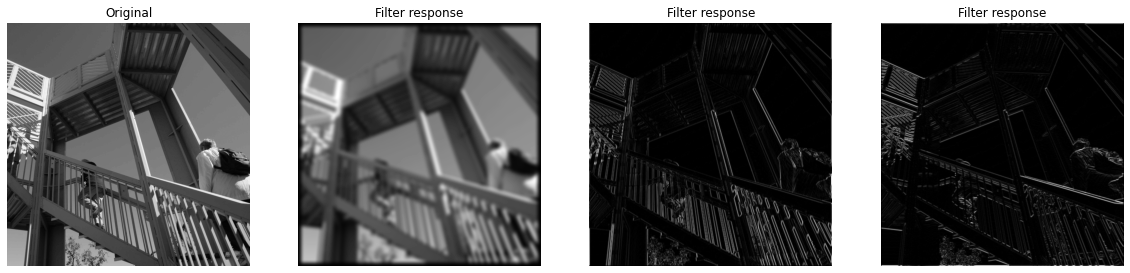

In [80]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

Question 3: What is the size of the different filters?

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?


Answer:

Q1: The Gaussian filter applies the gaussian kernel to the image. Because the filter is gaussian so it serves to smoothen the image by assigning a higher weight to the pixels at the center of the filter. This results in a gaussian blur on the image which helps in edge detection when followed by the Sobel filters. The SobelX filter detects for changing values when spanning from left to right, similarly, the SobelY filter detects for changing values from top to bottom. Thus the SobelX is a filter for vertical edge detection and SobelY is a filter for horizontal edge detection. The Gaussian filter is a low pass filter, while the Sobel filter is used as a follow up to the gaussian as a high pass filter.

Q2: The size of the original image as printed below is 512x512 px. It has only 1 channels since it is a greyscale image of only one of the primary colors, but generally a color image has 3 channels corresponding to RGB.

Q3: Gauss: 15x15, sobel filters are both 3x3

Q4: 512x512

Q5: filter size printed below. Valid convolution is done without padding, so if we are convolving a nxn image with fxf filter, the the filter response will be (n-f+1)x(n-f+1). For eg, in this case the 512x512 image is convolved with 15x15 gauss filter and the resulting response is a (512-15+1)x(512-15+1) i.e. 498x498.

Q6: Valid convolutions can run into problems of shrinking image sizes in deep CNNs. Evertime we use a valid convolution, we are left with a smaller image and after a number of convolutions, we can be left with an image that is too small or has too little imformation.

In [81]:
# Your code for checking sizes of image and filter responses

print(np.shape(gaussFilter))
print(np.shape(sobelX))
print(np.shape(sobelY))

print(np.shape(filterResponseGauss))
print(np.shape(filterResponseSobelX))
print(np.shape(filterResponseSobelY))


(15, 15)
(3, 3)
(3, 3)
(526, 526)
(514, 514)
(514, 514)


##  Part 3: Get a graphics card

Skip this part if you run on a CPU (recommended)

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [82]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

IndexError: list index out of range

##  Part 4: How fast is the graphics card?

Question 7: Why are the filters used for a color image of size 7 x 7 x 3, and not 7 x 7 ? 

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

Question 9: Do you think that a graphics card, compared to the CPU, is equally faster for convolving a batch of 1,000 images, compared to convolving a batch of 3 images? Motivate your answer.

Answer:

Q7: Since, typically color images have 3 channels, the filter used also much account for the dimensions of the channels.

Q8: Conv2D doesnt perform the same mathematical convolution that signal.convolve2d performs. The difference is that the Conv2D function doesnt mirror the kernel and is actually calculating the cross correlation.

Q9: With just 3 images, we are not giving the graphics card enough tasks for us to see a significant performace increase vs the CPU. But increasing the workload with 1000 images, we will see a significant increase in performance from the GPU

##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [83]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

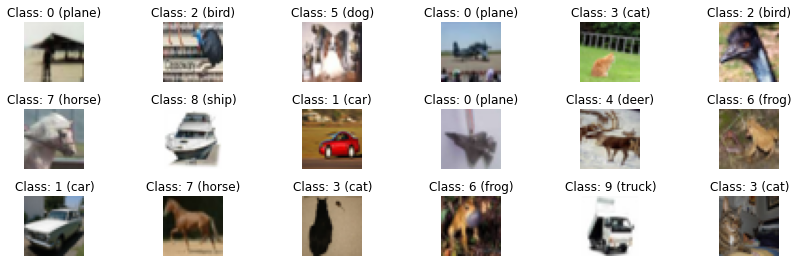

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [85]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, train_size=0.75 ,test_size=0.25)

# Print the size of training data, validation data and test data

print(Xtrain.shape)
print(Xval.shape)
print(Ytrain.shape)
print(Yval.shape)

(7500, 32, 32, 3)
(2500, 32, 32, 3)
(7500, 1)
(2500, 1)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [86]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/api/utils/python_utils/#to_categorical-function

In [87]:
from tensorflow.keras.utils import to_categorical

# Print shapes before converting the labels
print(np.shape(Ytrain))
print(np.shape(Ytest))
print(np.shape(Yval))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrainc = to_categorical(Ytrain)
Ytestc = to_categorical(Ytest)
Yvalc = to_categorical(Yval)

# Print shapes after converting the labels
print(np.shape(Ytrainc))
print(np.shape(Ytestc))
print(np.shape(Yvalc))

(7500, 1)
(2000, 1)
(2500, 1)
(7500, 10)
(2000, 10)
(2500, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/api/layers/core_layers/dense/ and https://keras.io/api/layers/reshaping_layers/flatten/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

In [88]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):
    
    # Optimizer
    opt = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(n_filters, (3, 3), input_shape = input_shape, padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
        n_filters = n_filters*2
        model.add(Conv2D(n_filters, (3, 3), activation='relu', padding = 'same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Add flatten layer
    model.add(Flatten())
    
    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes, activation = 'relu'))
        if use_dropout == True:
            model.add(Dropout(0.2))
        model.add(BatchNormalization())
             
    # Add final dense layer
    model.add(Dense(10, activation = 'softmax'))
   
    # Compile model
    model.compile(loss = 'categorical_crossentropy', optimizer = opt , metrics = ['accuracy'])
    
    # Return model
    return model

In [89]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

## 2 convolutional layers, no intermediate dense layers

In [91]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model1 = build_CNN(input_shape, n_conv_layers=2)

# Train the model  using training data and validation data
history1 = model1.fit(x=Xtrain,y=Ytrainc , epochs = 20 , validation_data = (Xval,Yvalc), batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 9s 108ms/step - loss: 3.0547 - accuracy: 0.3155 - val_loss: 2.0409 - val_accuracy: 0.3140
Epoch 2/20
75/75 [==============================] - 8s 105ms/step - loss: 1.5620 - accuracy: 0.4799 - val_loss: 1.6267 - val_accuracy: 0.4216
Epoch 3/20
75/75 [==============================] - 8s 111ms/step - loss: 1.2649 - accuracy: 0.5629 - val_loss: 1.4113 - val_accuracy: 0.4828
Epoch 4/20
75/75 [==============================] - 8s 104ms/step - loss: 1.0981 - accuracy: 0.6137 - val_loss: 1.2896 - val_accuracy: 0.5476
Epoch 5/20
75/75 [==============================] - 8s 107ms/step - loss: 1.0158 - accuracy: 0.6369 - val_loss: 1.2953 - val_accuracy: 0.5568
Epoch 6/20
75/75 [==============================] - 8s 104ms/step - loss: 0.9291 - accuracy: 0.6669 - val_loss: 1.2620 - val_accuracy: 0.5500
Epoch 7/20
75/75 [==============================] - 8s 101ms/step - loss: 0.8568 - accuracy: 0.7000 - val_loss: 1.3640 - val_accuracy: 0.5588
Epoch 

In [92]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest,Ytestc)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 16ms/step - loss: 2.8816 - accuracy: 0.5590
Test loss: 2.8816
Test accuracy: 0.5590


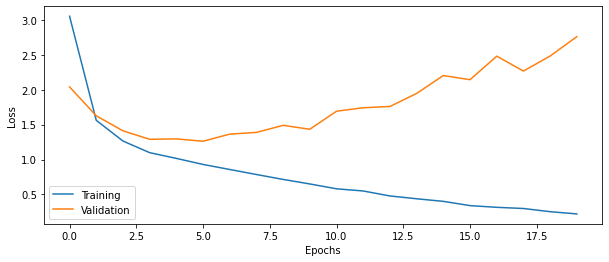

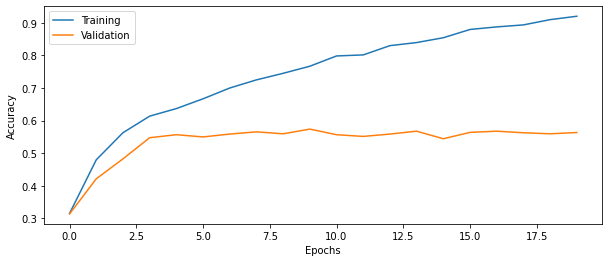

In [93]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 10: How big is the difference between training and test accuracy?

Question 11: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

Answer:

Q10: Training is around 56% whilst test is 40%, no we are not satisfied.

Q11: Because of the data being in the form of images it has much more features than the previous dataset which benefits having a samller batch size.

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [94]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model2 = build_CNN(input_shape, n_dense_layers=1)

# Train the model  using training data and validation data
history2 = model2.fit(x=Xtrain,y=Ytrainc , epochs = 20 , validation_data = (Xval,Yvalc), batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 10s 127ms/step - loss: 1.6636 - accuracy: 0.4091 - val_loss: 1.7159 - val_accuracy: 0.3772
Epoch 2/20
75/75 [==============================] - 9s 119ms/step - loss: 1.2881 - accuracy: 0.5384 - val_loss: 1.9397 - val_accuracy: 0.3080
Epoch 3/20
75/75 [==============================] - 9s 116ms/step - loss: 1.0749 - accuracy: 0.6131 - val_loss: 1.4565 - val_accuracy: 0.4756
Epoch 4/20
75/75 [==============================] - 10s 132ms/step - loss: 0.9147 - accuracy: 0.6833 - val_loss: 1.3855 - val_accuracy: 0.5368
Epoch 5/20
75/75 [==============================] - 8s 111ms/step - loss: 0.7251 - accuracy: 0.7440 - val_loss: 1.3845 - val_accuracy: 0.5768
Epoch 6/20
75/75 [==============================] - 10s 130ms/step - loss: 0.5690 - accuracy: 0.8007 - val_loss: 1.5801 - val_accuracy: 0.5580
Epoch 7/20
75/75 [==============================] - 9s 118ms/step - loss: 0.4494 - accuracy: 0.8429 - val_loss: 1.6920 - val_accuracy: 0.5680
Epo

In [95]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest,Ytestc)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 11ms/step - loss: 3.8254 - accuracy: 0.5265
Test loss: 3.8254
Test accuracy: 0.5265


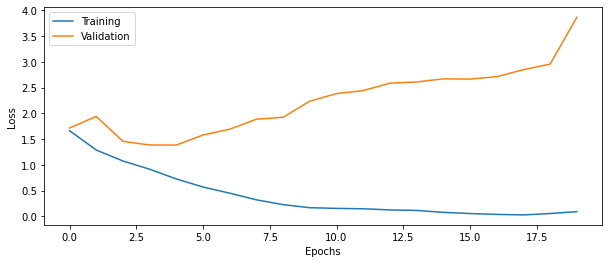

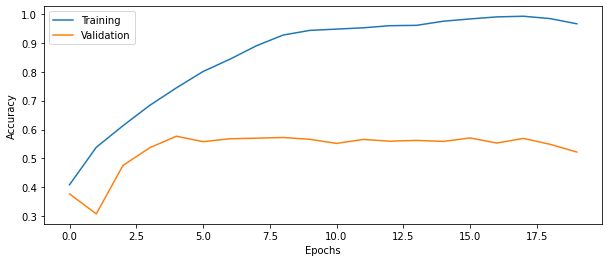

In [96]:
# Plot the history from the training run
plot_results(history2)

In [97]:
model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_47 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_48 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                     

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [98]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model3 = build_CNN(input_shape, n_dense_layers=1, n_conv_layers=4)

# Train the model  using training data and validation data
history3 = model3.fit(x=Xtrain,y=Ytrainc , epochs = 20 , validation_data = (Xval,Yvalc), batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 11s 134ms/step - loss: 1.7765 - accuracy: 0.3579 - val_loss: 2.7729 - val_accuracy: 0.2208
Epoch 2/20
75/75 [==============================] - 10s 137ms/step - loss: 1.3860 - accuracy: 0.4941 - val_loss: 1.6666 - val_accuracy: 0.4328
Epoch 3/20
75/75 [==============================] - 10s 136ms/step - loss: 1.1948 - accuracy: 0.5608 - val_loss: 1.9025 - val_accuracy: 0.4796
Epoch 4/20
75/75 [==============================] - 10s 133ms/step - loss: 1.0342 - accuracy: 0.6321 - val_loss: 1.8529 - val_accuracy: 0.4948
Epoch 5/20
75/75 [==============================] - 10s 137ms/step - loss: 0.8559 - accuracy: 0.6969 - val_loss: 1.4015 - val_accuracy: 0.5708
Epoch 6/20
75/75 [==============================] - 10s 136ms/step - loss: 0.7157 - accuracy: 0.7464 - val_loss: 1.6117 - val_accuracy: 0.5720
Epoch 7/20
75/75 [==============================] - 10s 137ms/step - loss: 0.5482 - accuracy: 0.8023 - val_loss: 2.1092 - val_accuracy: 0.5356

In [99]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest,Ytestc)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 17ms/step - loss: 2.5646 - accuracy: 0.6080
Test loss: 2.5646
Test accuracy: 0.6080


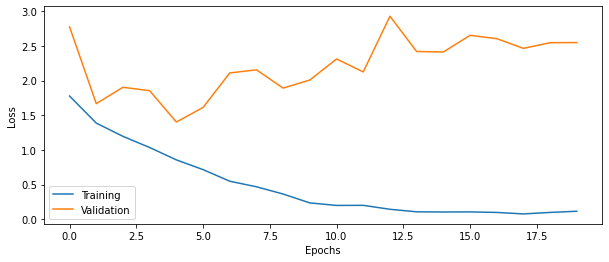

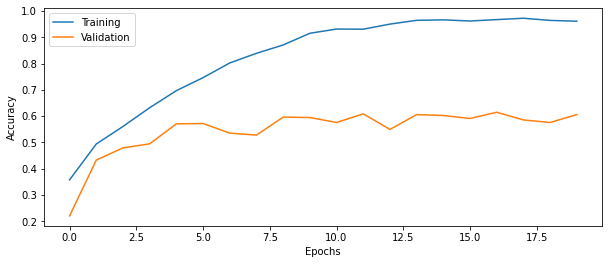

In [100]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 12: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

Question 13: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

Question 14: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Question 15: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

Question 16: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

Question 17: How does MaxPooling help in reducing the number of parameters to train?

Answer:

Q12: 124180, the last convolutionar layer contains the most amount of parameters per layer.

Q13: Input and output of every conv2d layer is a 4d tensor, the dimensions are batch_size, height, width, channels

Q14: Yes

Q15: 128 channels

Q16: This equality would hold in the case of greyscale image, where the number of channels of the input image is 1. But when we have an input with higher number of channels, then the filter would also convolve each channel separately and the number of parameters would increase that way.

Q17:It reduces the number of parameters by replacing the output of the net at each location with the 'max' summary statistic of nearby outputs.

In [101]:
# Print network architecture
model3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_52 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_53 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                     

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 18: How much did the test accuracy improve with dropout, compared to without dropout?

Question 19: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?


Answer:

Q18: Without dropout: 61%, With dropout: 57% so 4% decrease using dropout
    
Q19: Early stopping and data augmentation. By including kernel_regularizer='l2' 

## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [102]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model4 = build_CNN(input_shape, n_dense_layers=1, n_conv_layers=4, use_dropout= True)

# Train the model  using training data and validation data
history4 = model4.fit(x=Xtrain,y=Ytrainc , epochs = 20 , validation_data = (Xval,Yvalc), batch_size=batch_size) 

Epoch 1/20
75/75 [==============================] - 14s 164ms/step - loss: 1.8039 - accuracy: 0.3571 - val_loss: 1.9656 - val_accuracy: 0.3312
Epoch 2/20
75/75 [==============================] - 11s 145ms/step - loss: 1.4565 - accuracy: 0.4627 - val_loss: 2.5141 - val_accuracy: 0.2892
Epoch 3/20
75/75 [==============================] - 11s 146ms/step - loss: 1.2836 - accuracy: 0.5331 - val_loss: 1.9318 - val_accuracy: 0.3740
Epoch 4/20
75/75 [==============================] - 10s 140ms/step - loss: 1.1279 - accuracy: 0.5920 - val_loss: 1.2278 - val_accuracy: 0.5644
Epoch 5/20
75/75 [==============================] - 11s 151ms/step - loss: 1.0160 - accuracy: 0.6316 - val_loss: 1.6394 - val_accuracy: 0.4996
Epoch 6/20
75/75 [==============================] - 11s 147ms/step - loss: 0.8923 - accuracy: 0.6821 - val_loss: 1.7317 - val_accuracy: 0.5448
Epoch 7/20
75/75 [==============================] - 11s 149ms/step - loss: 0.7738 - accuracy: 0.7284 - val_loss: 1.3718 - val_accuracy: 0.5988

In [103]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest,Ytestc)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 14ms/step - loss: 2.5229 - accuracy: 0.5655
Test loss: 2.5229
Test accuracy: 0.5655


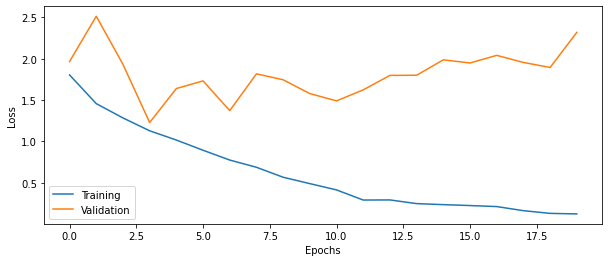

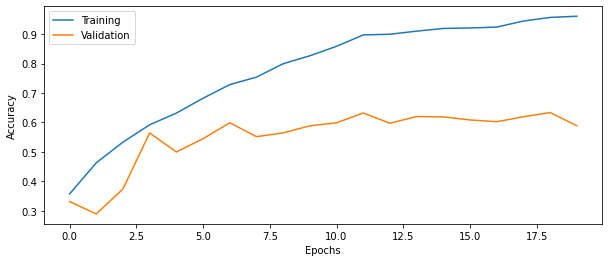

In [104]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 20: How high test accuracy can you obtain? What is your best configuration?

Answer:

Q20: 56%, best config: Batch size is 200, epochs are 20, dense layers are 1, conv layers are 4, nodes are 100 and dropout is disabled, filters are 16.

## Your best config

In [105]:
# Setup some training parameters
batch_size = 200
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model5 = build_CNN(input_shape, n_dense_layers=1, n_conv_layers=4, use_dropout= False, n_nodes = 100)

# Train the model  using training data and validation data
history5 = model5.fit(x=Xtrain,y=Ytrainc , epochs = 20 , validation_data = (Xval,Yvalc), batch_size=batch_size) 

Epoch 1/20
38/38 [==============================] - 12s 286ms/step - loss: 1.7951 - accuracy: 0.3700 - val_loss: 2.3005 - val_accuracy: 0.2908
Epoch 2/20
38/38 [==============================] - 11s 284ms/step - loss: 1.4031 - accuracy: 0.4764 - val_loss: 2.1462 - val_accuracy: 0.2996
Epoch 3/20
38/38 [==============================] - 11s 296ms/step - loss: 1.2305 - accuracy: 0.5487 - val_loss: 2.3910 - val_accuracy: 0.2520
Epoch 4/20
38/38 [==============================] - 10s 275ms/step - loss: 1.0675 - accuracy: 0.6167 - val_loss: 2.2453 - val_accuracy: 0.3232
Epoch 5/20
38/38 [==============================] - 12s 314ms/step - loss: 0.9008 - accuracy: 0.6759 - val_loss: 1.9150 - val_accuracy: 0.4180
Epoch 6/20
38/38 [==============================] - 11s 282ms/step - loss: 0.7455 - accuracy: 0.7348 - val_loss: 1.7213 - val_accuracy: 0.4608
Epoch 7/20
38/38 [==============================] - 10s 276ms/step - loss: 0.5990 - accuracy: 0.7888 - val_loss: 1.9459 - val_accuracy: 0.4744

In [106]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest,Ytestc)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 19ms/step - loss: 3.4210 - accuracy: 0.5575
Test loss: 3.4210
Test accuracy: 0.5575


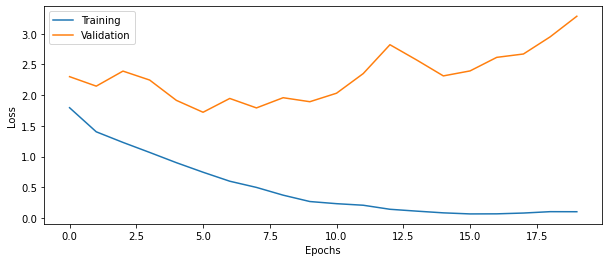

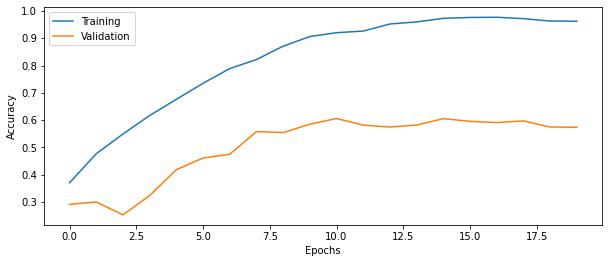

In [107]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 21: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

Answer:

Q21: 59% without rotated test images, 20% with rotated test images. This is expected results since the rotated test images recieve lower test accuracy than the non rotated images. This means that the CNN is not well generalized and less accurate with images that are not similar to the training data which in out case is images that are rotated. 

In [108]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

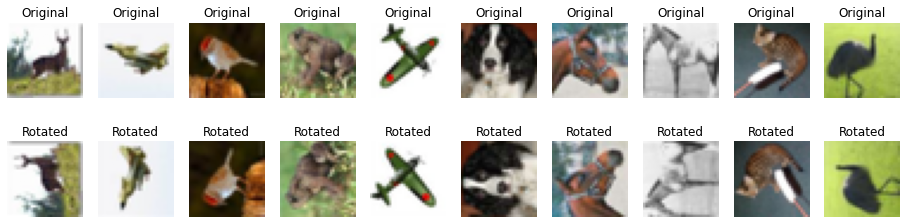

In [109]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [110]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated,Ytestc)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 17ms/step - loss: 7.7587 - accuracy: 0.2155
Test loss: 7.7587
Test accuracy: 0.2155


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator , the .flow(x,y) functionality

In [111]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [112]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator
IDG = ImageDataGenerator(rotation_range=30,horizontal_flip=True,vertical_flip=True)


# Setup a flow for training data, assume that we can fit all images into CPU memory
Setup_T_Flow = IDG.flow(x=Xtrain, y=Ytrain, batch_size=50)


# Setup a flow for validation data, assume that we can fit all images into CPU memory
Setup_V_Flow = IDG.flow(x=Xtrain, y=Ytrain, batch_size=50)


## Part 18: What about big data?

Question 22: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

Answer: 

Q22:
We could reduce the image size but we will risk loosing important features of the image in that case. Also the main task could be to stream the data from the harddrive instead of storing everything at the same time in the CPU memory. Distadvantage of this is the speed of the streaming and how fast we can access the data will be reduced. We could also read the images by batch instead of using the memory.

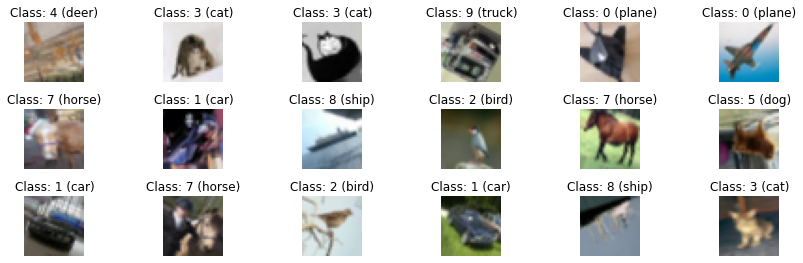

In [113]:
# Plot some augmented images
plot_datagen = IDG.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/api/models/model_training_apis/#fit-method for how to use model.fit with a generator instead of a fix dataset (numpy arrays)

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 23: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

Question 24: What other types of image augmentation can be applied, compared to what we use here?

Answer:

Q23: It increases much faster without augmentation. This is also do to more features being trained sinze augmentation introduces more generalization instead of overfitting. Epochs are needed be increased to do more training.

Q24: Examples: cropping by zooming, change of brightness and color augmentation

In [114]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = Xtrain.shape[1:]

# Build model (your best config)
model6 = build_CNN(input_shape, n_dense_layers=2, n_conv_layers=3, use_dropout= True, n_nodes = 100)

validation_split=0.2
    
# Train the model using on the fly augmentation
history6 = model6.fit_generator(IDG.flow(Xtrain, Ytrain, batch_size=batch_size), epochs=epochs, steps_per_epoch=Xtrain.shape[0]/batch_size,
                    validation_data=Setup_V_Flow, validation_steps=Xtest.shape[0]/batch_size)

Epoch 1/200


C:\Users\dinud\AppData\Local\Temp/ipykernel_13592/2226790530.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6 = model6.fit_generator(IDG.flow(Xtrain, Ytrain, batch_size=batch_size), epochs=epochs, steps_per_epoch=Xtrain.shape[0]/batch_size,


100/100 [==============================] - 20s 184ms/step - loss: 1.9651 - accuracy: 0.2923 - val_loss: 1.9526 - val_accuracy: 0.2980
Epoch 2/200
100/100 [==============================] - 17s 173ms/step - loss: 1.6764 - accuracy: 0.3829 - val_loss: 1.9635 - val_accuracy: 0.3250
Epoch 3/200
100/100 [==============================] - 17s 173ms/step - loss: 1.5943 - accuracy: 0.4150 - val_loss: 1.7787 - val_accuracy: 0.4090
Epoch 4/200
100/100 [==============================] - 18s 178ms/step - loss: 1.5092 - accuracy: 0.4505 - val_loss: 1.5473 - val_accuracy: 0.4520
Epoch 5/200
100/100 [==============================] - 17s 169ms/step - loss: 1.4736 - accuracy: 0.4657 - val_loss: 1.4922 - val_accuracy: 0.4560
Epoch 6/200
100/100 [==============================] - 16s 159ms/step - loss: 1.4053 - accuracy: 0.4859 - val_loss: 1.4767 - val_accuracy: 0.4900
Epoch 7/200
100/100 [==============================] - 16s 164ms/step - loss: 1.3806 - accuracy: 0.4977 - val_loss: 1.4147 - val_accurac

Epoch 57/200
100/100 [==============================] - 15s 155ms/step - loss: 0.8663 - accuracy: 0.6943 - val_loss: 0.7865 - val_accuracy: 0.7260
Epoch 58/200
100/100 [==============================] - 16s 159ms/step - loss: 0.8649 - accuracy: 0.6966 - val_loss: 0.7565 - val_accuracy: 0.7260
Epoch 59/200
100/100 [==============================] - 16s 156ms/step - loss: 0.8504 - accuracy: 0.7028 - val_loss: 0.7411 - val_accuracy: 0.7390
Epoch 60/200
100/100 [==============================] - 15s 153ms/step - loss: 0.8474 - accuracy: 0.7021 - val_loss: 0.7597 - val_accuracy: 0.7100
Epoch 61/200
100/100 [==============================] - 15s 153ms/step - loss: 0.8484 - accuracy: 0.6962 - val_loss: 0.7990 - val_accuracy: 0.7060
Epoch 62/200
100/100 [==============================] - 17s 165ms/step - loss: 0.8331 - accuracy: 0.7108 - val_loss: 0.7682 - val_accuracy: 0.7180
Epoch 63/200
100/100 [==============================] - 16s 159ms/step - loss: 0.8502 - accuracy: 0.7000 - val_loss: 0

100/100 [==============================] - 16s 159ms/step - loss: 0.7291 - accuracy: 0.7388 - val_loss: 0.6113 - val_accuracy: 0.7900
Epoch 113/200
100/100 [==============================] - 15s 154ms/step - loss: 0.7320 - accuracy: 0.7408 - val_loss: 0.5685 - val_accuracy: 0.7960
Epoch 114/200
100/100 [==============================] - 16s 160ms/step - loss: 0.7290 - accuracy: 0.7449 - val_loss: 0.6751 - val_accuracy: 0.7550
Epoch 115/200
100/100 [==============================] - 17s 168ms/step - loss: 0.7315 - accuracy: 0.7430 - val_loss: 0.6147 - val_accuracy: 0.7790
Epoch 116/200
100/100 [==============================] - 16s 162ms/step - loss: 0.7075 - accuracy: 0.7489 - val_loss: 0.5926 - val_accuracy: 0.7860
Epoch 117/200
100/100 [==============================] - 15s 146ms/step - loss: 0.7101 - accuracy: 0.7503 - val_loss: 0.6190 - val_accuracy: 0.8040
Epoch 118/200
100/100 [==============================] - 13s 128ms/step - loss: 0.7195 - accuracy: 0.7480 - val_loss: 0.6071 -

100/100 [==============================] - 11s 113ms/step - loss: 0.6340 - accuracy: 0.7755 - val_loss: 0.5247 - val_accuracy: 0.8140
Epoch 168/200
100/100 [==============================] - 12s 117ms/step - loss: 0.6663 - accuracy: 0.7667 - val_loss: 0.5494 - val_accuracy: 0.8150
Epoch 169/200
100/100 [==============================] - 11s 114ms/step - loss: 0.6484 - accuracy: 0.7755 - val_loss: 0.4979 - val_accuracy: 0.8280
Epoch 170/200
100/100 [==============================] - 12s 118ms/step - loss: 0.6326 - accuracy: 0.7760 - val_loss: 0.5773 - val_accuracy: 0.7930
Epoch 171/200
100/100 [==============================] - 12s 123ms/step - loss: 0.6327 - accuracy: 0.7805 - val_loss: 0.4968 - val_accuracy: 0.8180
Epoch 172/200
100/100 [==============================] - 12s 116ms/step - loss: 0.6501 - accuracy: 0.7689 - val_loss: 0.6095 - val_accuracy: 0.7880
Epoch 173/200
100/100 [==============================] - 12s 115ms/step - loss: 0.6484 - accuracy: 0.7661 - val_loss: 0.5306 -

In [115]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytestc, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytestc, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.0785
Test accuracy: 0.6645
Test loss: 2.7424
Test accuracy: 0.3195


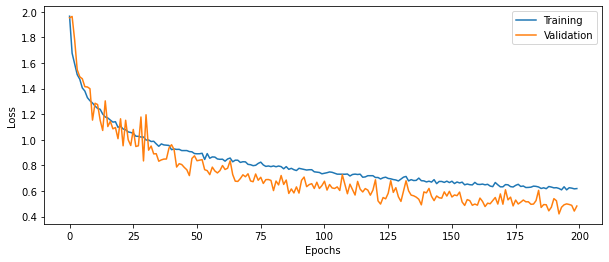

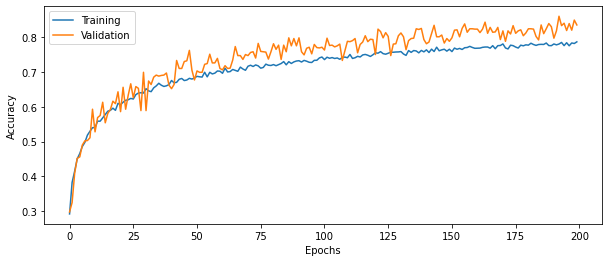

In [116]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly, these cells are already finished.

In [117]:
# Find misclassified images
y_pred=model6.predict(Xtest) 
y_pred=np.argmax(y_pred,axis=1)

y_correct = np.argmax(Ytestc,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

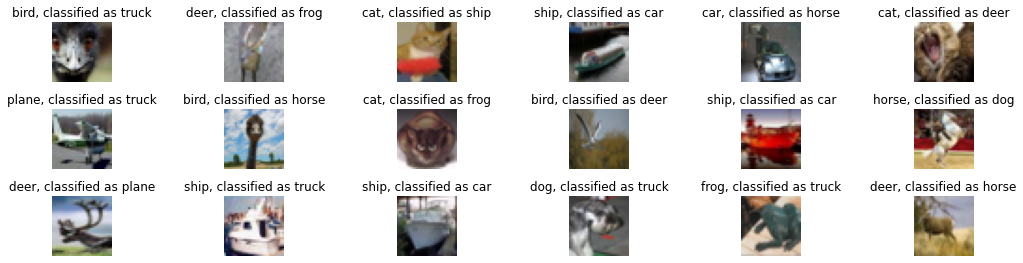

In [118]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 25: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Question 26: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

Answer:

Q25: Since there is a dense layer cannot handle different image sizes we cannot use other image sizes even though the convolutional layers can handle it.

Q26: We will need to get rid of the dense layer. We could also resize the image but that is not desirable.


##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 27: How many convolutional layers does ResNet50 have? 

Question 28: How many trainable parameters does the ResNet50 network have? 

Question 29: What is the size of the images that ResNet50 expects as input?

Question 30: Using the answer to question 28, explain why the second derivative is seldom used when training deep networks.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/api/applications/ and https://keras.io/api/applications/resnet/#resnet50-function 

Useful functions

`image.load_img` in tensorflow.keras.preprocessing

`image.img_to_array` in tensorflow.keras.preprocessing

`ResNet50` in tensorflow.keras.applications.resnet50

`preprocess_input` in tensorflow.keras.applications.resnet50

`decode_predictions` in tensorflow.keras.applications.resnet50

`expand_dims` in numpy


Answer:

Q27: 48 convolutional layers

Q28: 25 million

Q29: 224x224 pixel dimension with 3 channels.

Q30: It would be more computationaly costly and complex, especially regarding the 25 million from Q28

('warplane', 0.751283)


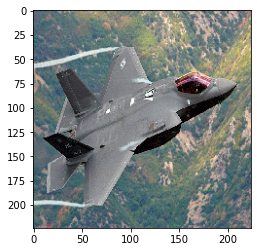

('airliner', 0.5890097)


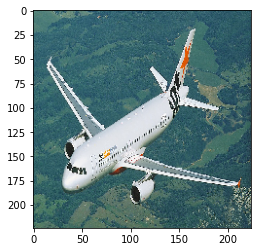

('tusker', 0.6116513)


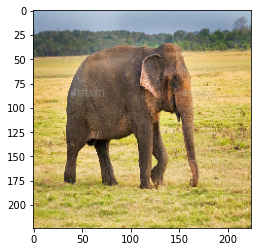

('African_elephant', 0.9019247)


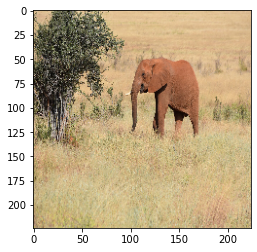

('African_elephant', 0.6654924)


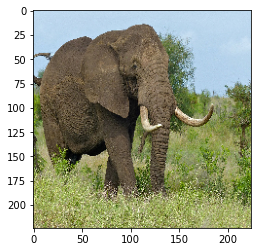

In [119]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice. 
# The preprocessing should transform the image to a size that is expected by the CNN.
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

im_l= ['f35.png','airbus.jpg','slele.jpg','inele.jpg','afele.jpg']

for i in range(len(im_l)):
    im_name = im_l[i]
    im = image.load_img(im_name, target_size=(224, 224))
    inp = image.img_to_array(im)
    inp = np.expand_dims(inp, axis=0)
    inp = preprocess_input(inp)
    model_res = ResNet50()
    predLabs = decode_predictions(model_res.predict(inp))
    print(predLabs[0][0][1:3])
    plt.imshow(im)
    plt.show()


The predictions are all correct except the last image. This should be a indian elephant but since the model prediction is 66% certain it is a african elephant, it could be found that the publisher of this image might have made a misstake and that we now correctly labeled it as in actuality an african elephant.

In [120]:
model_res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       